In [167]:
# -*- coding: utf-8 -*-
# Author: Marzieh sepehr
# Date: 08-01-2021

import collections
import re
import string

import preprocessor as p
import numpy as np
import networkx as nx
import pandas as pd

from nltk import word_tokenize
from nltk.corpus import stopwords


class KECNW():

    def __init__(self,
                 _dataset_df,
                 _text_field_name):
        self.graph = nx.Graph()

        self.dataset_df = _dataset_df
        self.text_field_name = _text_field_name
        self.preprocess()
        self.build_graph()
        self.keyphrase_candidates = set([])
        self.words = []

        self.documents = list(_dataset_df[_text_field_name])

        self.generate_candidates()
        self.node_weight_assignment()

    def build_graph(self):
        """
        Phase 2: textual graph representation and
        """

        # step i: Vertex assignment
        self.words = list(set(list(sum(list(self.dataset_df['text_pre']), []))))

        num_of_nodes = len(self.words)
        for i in range(num_of_nodes):
            self.graph.add_node(self.words[i])

        # step ii: Edging
        # The edges are established by pairs of tokens read in the same sequence
        # in which they appear in the original texts.So an edge Ei,j is generated for each token “i” and
        # its immediate successor “j” (it means we should find all bigrams like "node[i] node[j]" in texts

        self.W_c = np.zeros((num_of_nodes, num_of_nodes))
        for i in range(num_of_nodes):
            for j in range(num_of_nodes):
                bigram = str.format('{} {}'.format(self.words[i], self.words[j]))
                # freq_i_j = self.dataset_df[self.dataset_df[self.text_field_name].str.contains(str.format('{} {}'.format(words[i],words[j])))]
                try:
                    freq_i_j = self.dataset_df[self.text_field_name].str.count(bigram).sum()
                    freq_i = self.dataset_df[self.text_field_name].str.count(self.words[i]).sum()
                    freq_j = self.dataset_df[self.text_field_name].str.count(self.words[j]).sum()
                except re.error:
                    print(bigram)

                # build adjacency matrix
                _weight = freq_i_j / (freq_i + freq_j - freq_i_j)
                self.W_c[i][j] = _weight

                # add edge if token "i" immediate successor of token "j"

                if freq_i_j != 0:
                    self.graph.add_edge(self.words[i], self.words[j], weight=_weight)

    def generate_candidates(self):
        """

        In this paper all node is our keyword candid but we can change
        this method in arbitrary way by filtering some specific words

        """
        self.keyphrase_candidates = self.words

    def node_weight_assignment(self):
        """
        Phase 3: node weight assignment
        """
        self._set_node_distance_from_central_node()
        self._set_node_selectivity_centrality()
        self._set_importance_of_neighboring_nodes()
        self._set_node_position_of_a_node()
        self._set_node_tf()

    def _set_node_selectivity_centrality(self):
        """
        Selectivity Centrality
        """

        self.selectivity_dict = {}
        for node in self.graph.nodes():
            # s(v): The strength of a node. sum of the weights of all edges incident with the node v.
            sv = self.graph.degree(node, weight="weight")
            # d(v): vertex degree node v
            dv = self.graph.degree(node, weight=None)
            if dv > 0:

                selectivity = sv / dv
                self.selectivity_dict[node] = {'SC': selectivity}
            else:
                self.selectivity_dict[node] = {'SC': 0}

        nx.set_node_attributes(self.graph, self.selectivity_dict)

    def _set_importance_of_neighboring_nodes(self):
        """
        Importance of neighboring nodes
        """

        self.importance_of_neighbors = dict()
        for node in self.graph.nodes():
            sigma_strength = 0
            for node_j in self.graph.neighbors(node):
                strength_j = self.graph.degree(node_j, weight="weight")
                sigma_strength += strength_j
            N = len([a for a in self.graph.neighbors(node)])
            try:
                self.importance_of_neighbors[node] = {'Neigh_Imp': sigma_strength / N}
            except ZeroDivisionError:
                self.importance_of_neighbors[node] = {'Neigh_Imp': 0}

        nx.set_node_attributes(self.graph, self.importance_of_neighbors)

    def _set_node_position_of_a_node(self):
        """
         Position of a node
        """
        self.first_position_weight = dict()
        self.last_position_weight = dict()
        for node in self.graph.nodes():
            n_f = 0
            n_l = 0
            for text in self.documents:
                if str(text).startswith(node):
                    n_f += 1
                if str(text).endswith(node):
                    n_l += 1
            freq_i = self.dataset_df[self.text_field_name].str.count(node).sum()
            import warnings

            with warnings.catch_warnings():
                warnings.filterwarnings('error')
                try:
                    F_i = n_f / freq_i
                    L_i = n_l / freq_i
                except Warning as e:
                    print('error found:', e)

            self.first_position_weight[node] = {'F': F_i}
            self.last_position_weight[node] = {'L': L_i}

        nx.set_node_attributes(self.graph, self.first_position_weight)
        nx.set_node_attributes(self.graph, self.last_position_weight)

    def _set_node_tf(self):
        """
        Term frequency:
        """
        self.TF = dict()

        for node in self.graph.nodes():
            freq_i = self.dataset_df[self.text_field_name].str.count(node).sum()
            self.TF[node] = {'TF': freq_i}
        nx.set_node_attributes(self.graph, self.TF)

    def _set_node_distance_from_central_node(self):
        """
        Distance from central node
        """

        # find central node
        sorted_degrees = sorted(self.graph.degree, key=lambda x: x[1], reverse=True)
        central_node = sorted_degrees[0][0]

        # calculates the lengths of the shortest paths between all nodes in graph
        # (self.graph is a wighted graph so we use all_pairs_shortest_path_length)
        shortest_pathes = dict(nx.all_pairs_shortest_path_length(self.graph))

        # calculate Distance from central node and add to node as attribute
        self.DC = dict()
        for node in self.graph.nodes():

            try:
                self.DC[node] = {'DC': 1 / (shortest_pathes[node][central_node])}
            except ZeroDivisionError:
                self.DC[node] = {'DC': 1}
            except KeyError:
                # it happen when there is no way between two node
                self.DC[node] = {'DC': 1 / 1000000}

        nx.set_node_attributes(self.graph, self.DC)

    def set_weighting_criteria(self, criterias=[]):
        """

        calculate Node_weight(i) and Final_weight(i)

        :criterias: list of criteria for weighing node could be any combination of :

        [DC, SC,Neigh_Imp,F,L,TF]
        DC: Distance from central node
        SC: Selectivity Centrality:
        Neigh_Imp: Importance of neighboring nodes
        F :  Position of a node (nf/freq(i), where, nf is the number of times i is the first word)
         freq(i) is the frequency of the term i
        L :  Position of a node (nl/freq(i), where, nl is the number of times i is the last word)
         freq(i) is the frequency of the term i
        TF: Term frequency


        Output: set Final_weight attribute for each node

        """
        node_weights_atts = {}
        for node in self.graph.nodes():
            _node_weight = 0
            if 'DC' in criterias:
                _node_weight += self.graph.nodes[node]['DC']
            if 'SC' in criterias:
                _node_weight += self.graph.nodes[node]['SC']
            if 'Neigh_Imp' in criterias:
                _node_weight += self.graph.nodes[node]['Neigh_Imp']
            if 'F' in criterias:
                _node_weight += self.graph.nodes[node]['F']
            if 'L' in criterias:
                _node_weight += self.graph.nodes[node]['L']
            if 'TF' in criterias:
                _node_weight += self.graph.nodes[node]['TF']

            node_weights_atts[node] = {'Node_weight': _node_weight}

        nx.set_node_attributes(self.graph, node_weights_atts)

        min_weight = min(list(nx.get_node_attributes(self.graph, 'Node_weight').values()))
        max_weight = max(list(nx.get_node_attributes(self.graph, 'Node_weight').values()))

        final_weights_atts = {}
        for node in self.graph.nodes():
            _node_final_weight = (self.graph.nodes[node]['Node_weight'] - min_weight) / (max_weight - min_weight)
            final_weights_atts[node] = {'Final_weight': _node_final_weight}

        nx.set_node_attributes(self.graph, final_weights_atts)

    def _pre_process(self, text):
        """
        Preprocess text includding following steps:
        1) Remove username and retweet symbol and URL and hash tag
        2)tokenize
        3)remove stopwords
        4)remove Additional white spaces
        """
        # Remove username and retweet symbol and URL and hash tag
        p.set_options(p.OPT.MENTION, p.OPT.RESERVED, p.OPT.URL, p.OPT.HASHTAG)
        t = p.clean(text)
        # remove multiple dots
        t=re.sub(r'\.\.+', ' ', text).replace('.', '')
        t=re.sub(r'\'+', ' ', t).replace('\'', '')
        t=re.sub(r'\"+', ' ', t).replace('\"', '')
        t=re.sub(r'\”+', ' ', t).replace('\”', '')
        t=re.sub(r'\“+', ' ', t).replace('\“', '')
        t=re.sub(r'\’+', ' ', t).replace('\’', '')
        
        # t=t.lower()
        # tokenize
        word_tokens = word_tokenize(t)
        # remove stopwords
        stop_words = set(stopwords.words('english') + list(set(string.punctuation)))
        filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
        # remove Additional white spaces
        filtered_sentence = [a.strip() for a in filtered_sentence]
        return filtered_sentence

    def preprocess(self):
        """
         Phase 1: pre-processing
        """

        # preprocess part 1 including preprocess step i to step v in base article
        self.dataset_df['text_pre_part1'] = self.dataset_df[self.text_field_name].apply(lambda x: self._pre_process(x))

        # preprocess part 2  # Removal of unimportant tokens

        # calculate AOF
        all_tokens = list(sum(list(self.dataset_df['text_pre_part1']), []))
        sum_Frequency_of_each_node = len(all_tokens)
        Number_of_nodes = len(list(set(all_tokens)))
        AOF = sum_Frequency_of_each_node / Number_of_nodes
        Frequency_of_each_node = collections.Counter(all_tokens)
        # find unimportant tokens
        unimportant_tokens = [t[0] for t in Frequency_of_each_node.items() if t[1] < AOF]
        # remove unimportant tokens
        self.dataset_df['text_pre_part2'] = self.dataset_df['text_pre_part1'].apply(
            lambda x: [i for i in x if i not in unimportant_tokens])
        # save preprocessed document is text_pre column of dataset
        self.dataset_df['text_pre'] = self.dataset_df['text_pre_part2']
        # drop row with null text preprocessed
        # self.dataset_df = self.dataset_df[~self.dataset_df.text_pre_part2.str.len().eq(0)]

    def get_preprocessed_documents_as_list(self):
        return self.dataset_df['text_pre']

    def keyword_extraction(self, d=0.85,n_best=10):
        """
        d: damping factor for TextRank
        i. Calculate the NE rank

        """
        # i. Calculate the NE rank and set R(v_i) as "R" attribute to each node
        relevance_atts = {}
        for node_i in self.graph.nodes():

            # sigma j:vj ->vi
            sigma_j = 0
            for node_j in self.graph.neighbors(node_i):
                w_j_i = self.graph[node_j][node_i]['weight']
                # sigma k:vj
                sigma_kj = 0
                for node_k in self.graph.neighbors(node_j):
                    sigma_kj += self.graph[node_j][node_k]['weight']

                sigma_j += ((w_j_i) / sigma_kj)

            relavance_i = (1 - d) * self.graph.nodes[node_i]['Final_weight'] + d * self.graph.nodes[node_i][
                'Final_weight'] * sigma_j
            relevance_atts[node_i] = {'Ne_r': relavance_i}
        nx.set_node_attributes(self.graph, relevance_atts)

        # ii. Calculate the degree centrality and set it as "degree" attribute to each node
        degree_centrality = {}
        for node in self.graph.nodes():
            degree_centrality[node] = {'degree': self.graph.degree[node]}

        nx.set_node_attributes(self.graph, degree_centrality)

        # iii. Sort the keywords
        sorted_keywords = sorted(nx.get_node_attributes(self.graph, 'Ne_r').items(), key=lambda x: x[1], reverse=True)
        sorted_keywords_refined = []
        for i in range(len(sorted_keywords) - 1):
            node_i = sorted_keywords[i]
            node_j = sorted_keywords[i + 1]
            # degree as tie breaker
            if node_i[1] == node_j[1]:
                if self.graph.nodes[node_i[0]]['degree'] < self.graph.nodes[node_j[0]]['degree']:
                    temp = node_i
                    sorted_keywords[i] = node_j
                    sorted_keywords[i + 1] = temp
        return sorted_keywords[0:n_best]



In [185]:
donald_dataset = pd.read_csv('data/trump_20200530.csv')

print('-------------List of donald trump tweets----------------')
list(donald_dataset['text'])[0:10]

-------------List of donald trump tweets----------------


['RT @ScottAdamsSays: Malaria drug and zinc the missing link https://t.co/FC9CpuH0Yr via @theconwom',
 'RT @YoungDems4Trump: In Democrat cities you can get arrested for opening a business but not for looting one. #MinneapolisRiot #Coronavirus',
 'RT @YoungDems4Trump: So sad. This poor business owner lost everything due to the  #MinneapolisRiothttps://t.co/mK0nHFNthS',
 'Time for a change! #2020 https://t.co/AECy2GBfys',
 'RT @TallahForTrump: Trump spoke at my church in Detroit and it opened my eyes. Never again will I be a slave to the Democrats!👊 Let us rise…',
 'RT @TheRightMelissa: In an ironic twist of fate CNN HQ is being attacked by the very riots they promoted as noble &amp; just. Oops',
 'RT @Jim_Jordan: Right on! We don’t have to pay organizations to lie to us. They’ll probably do it for free.',
 'RT @Scavino45: “Texas AG Ken Paxton: Trump is right and Twitter ‘fact check’ is wrong – mail-in ballot fraud is a real problem” https://t.c…',
 'RT @Jim_Jordan: Twitter “fact checks”

In [169]:
donald_dataset=donald_dataset.head(50)
g = KECNW(_dataset_df=donald_dataset, _text_field_name="text")
g.set_weighting_criteria(criterias=['DC', 'SC', 'Neigh_Imp', 'F', 'L','TF'])

In [174]:
keys = g.keyword_extraction(n_best=10)
keys

   

[('transit', 1.6350553242072077),
 ('us', 0.47129910318522356),
 ('Trump', 0.4327077170921656),
 ('USDOT', 0.41299218371606605),
 ('people', 0.3388970911781902),
 ('bus', 0.23076724007615962),
 ('fact', 0.2134270277589387),
 ('State', 0.2080921487912149),
 ('service', 0.17125253724226244),
 ('George', 0.16253215493065365)]

In [175]:
keys_nodes=[a[0] for a in keys]


In [176]:
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
   

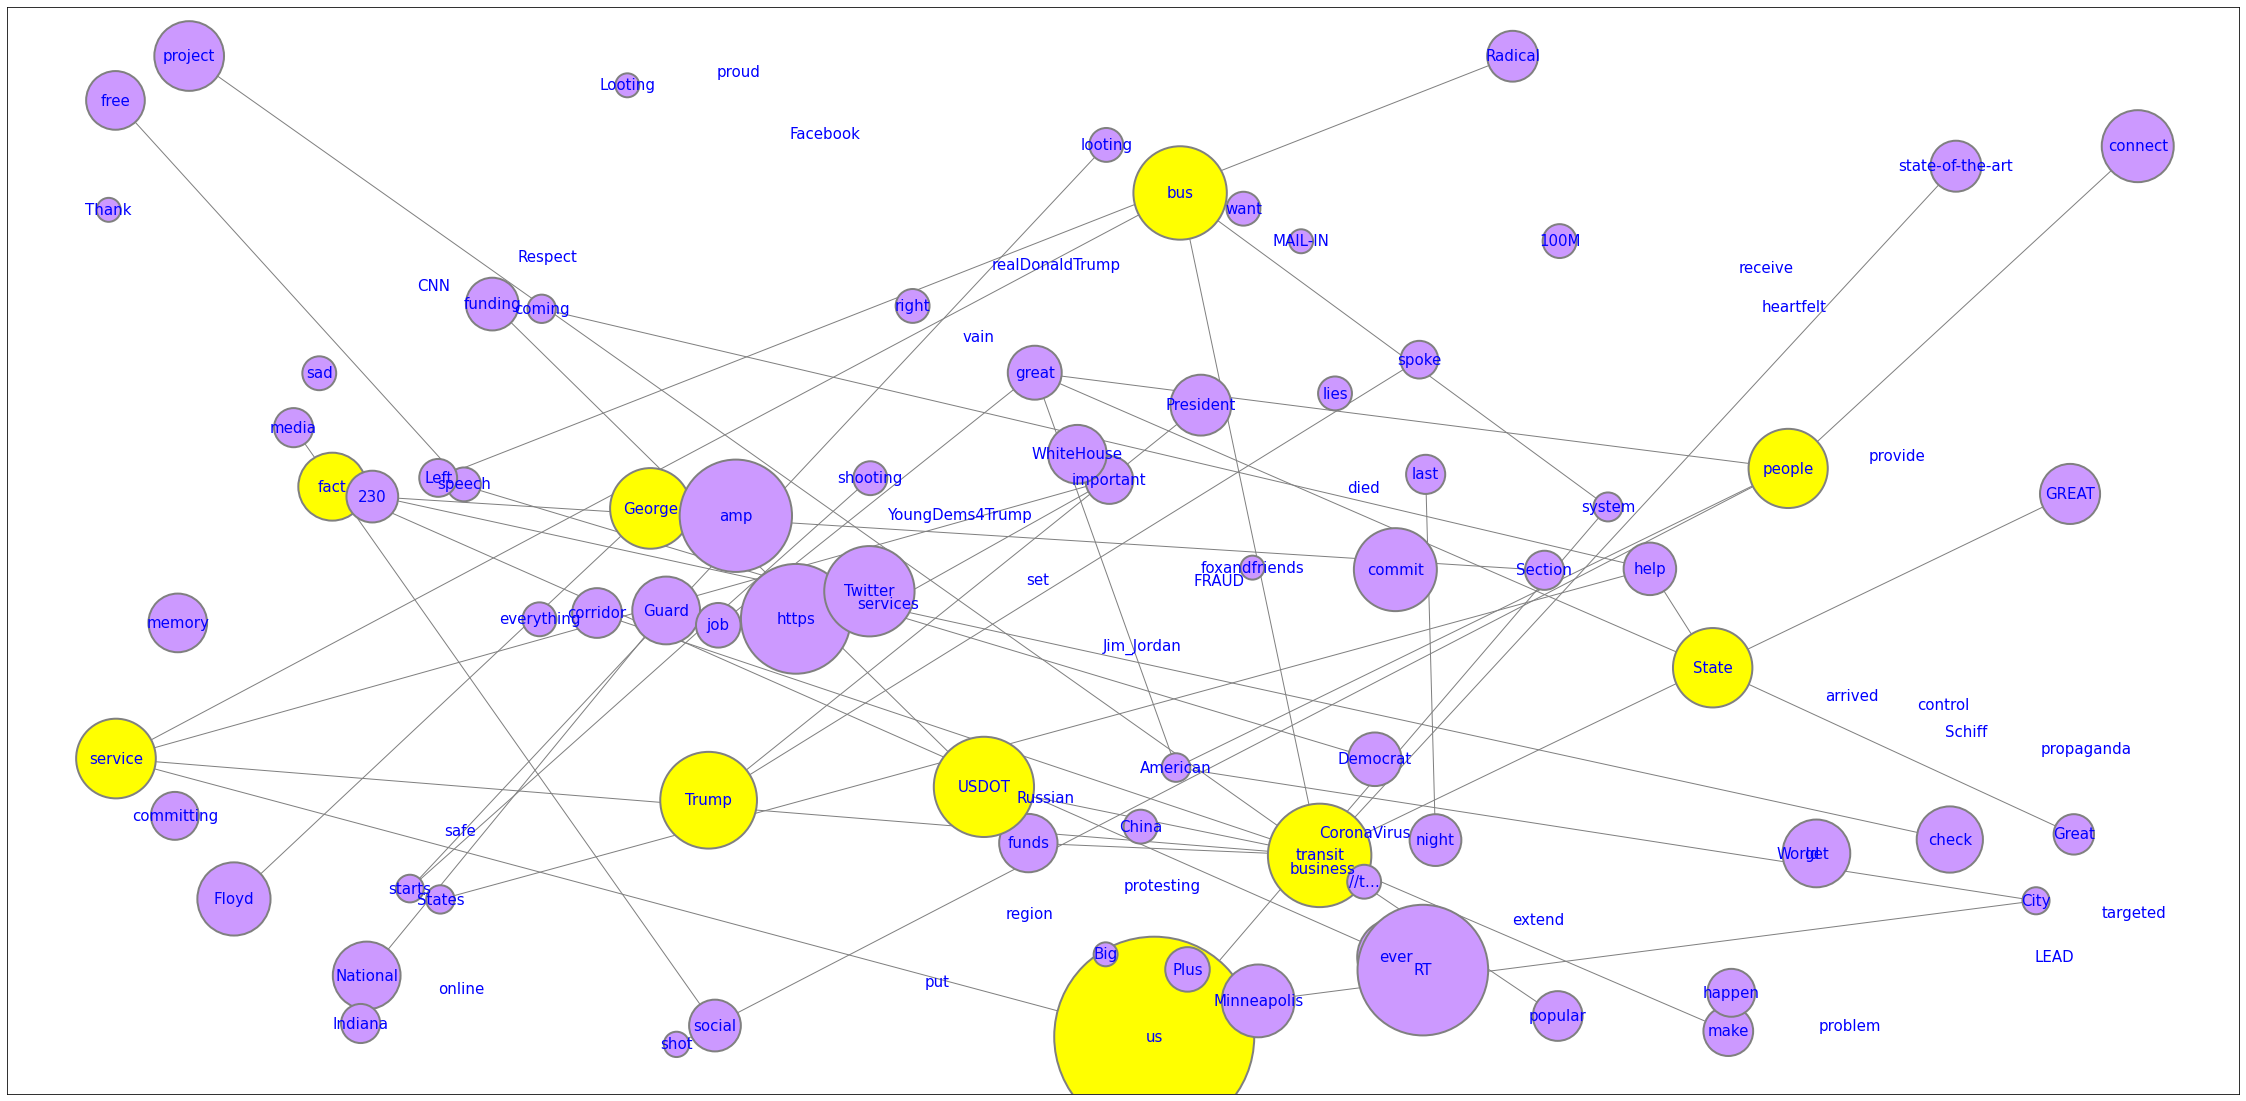

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(40, 20));
G=g.graph
node_sizes = []
labels = {}
color_map = []

for n in G.nodes:
        a=G.nodes[n]['Final_weight']*40000
        node_sizes.append(a)
        labels[n] =n
        if n in keys_nodes:
            color_map.append('yellow')
        else:
            color_map.append('#cc99ff')
            
            
        
options = {
    'edgecolors':'grey',
    'edge_color':'gray',
    'font_color':'blue',
    'node_color': color_map,
    'node_size': node_sizes,
    'labels': labels,
    'width': 1,
    'linewidths':2,
    'font_size': 15
}
# nx.draw_networkx(G, ax=ax,arrows=True, **options,with_labels=True)
# nx.draw_random(G, node_size = node_sizes, labels=labels, with_labels=True)   
pos = nx.random_layout(G)
nx.draw_networkx(G, ax=ax,arrows=True, **options, with_labels=True,pos=pos) 


In [39]:
nx.write_gexf(g.graph, "file2.gexf", version="1.2draft")

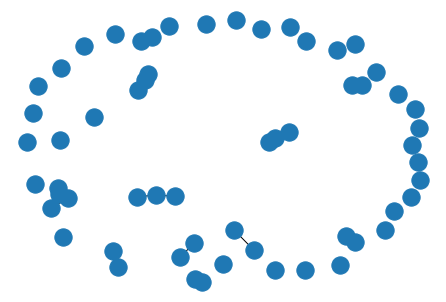

In [38]:
options = {
    'node_color': 'yellow',
    'node_size': 500,
    'width': 3,
    'arrowstyle': '-|>',
    'arrowsize': 12,
    'font_size': 20
}

# nx.draw_networkx(g.graph, arrows=True, **options)
G=g.graph
pos = nx.spring_layout(G)

nx.draw(G, pos)
node_labels = nx.get_node_attributes(G,'Final_weight')
nx.draw_networkx_labels(G, pos, labels = node_labels)
node_labels
edge_labels = nx.get_edge_attributes(G,'weight')
edge_labels
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)


from matplotlib import pyplot as plt
plt.savefig('this.png')
plt.show()
